# Bias Correction para Datos CMIP6 ACCESS-CM2

Este notebook implementa bias correction usando quantile mapping (DQM/EQM) para datos históricos y proyecciones SSP del modelo ACCESS-CM2, usando CR2MET como referencia observacional.

## Región: Valle de Aconcagua, Chile
- **Variables**: pr, tasmin, tasmax
- **Período calibración**: 1980-2014
- **Método**: Detrended Quantile Mapping (DQM)
- **Resolución**: 0.05° (rejilla CR2MET)

## 1. Import Libraries and Setup

In [1]:
# Imports básicos para bias correction
import xarray as xr
import pandas as pd
import numpy as np
import warnings
from pathlib import Path
import time
from datetime import datetime
import sys

warnings.filterwarnings('ignore')

print("=" * 70)
print("🎯 BIAS CORRECTION PIPELINE - ACCESS-CM2")
print("=" * 70)
print(f"Inicio: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"xarray version: {xr.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")

🎯 BIAS CORRECTION PIPELINE - ACCESS-CM2
Inicio: 2025-10-12 20:14:19
xarray version: 2025.1.2
pandas version: 2.3.3
numpy version: 2.3.3


In [2]:
# Imports específicos para bias correction
import xclim.sdba as sdba
from xclim import set_options
import dask
from dask.diagnostics import ProgressBar

# Configurar dask para manejo eficiente de memoria
dask.config.set({
    'scheduler': 'threads',
    'array.chunk-size': '128MiB',
    'array.slicing.split_large_chunks': True
})

# Configurar xclim para logging
set_options(data_validation='log')

print("✅ Imports específicos completados:")
print(f"  • xclim.sdba: {sdba.__name__}")
print(f"  • dask scheduler: {dask.config.get('scheduler')}")
print(f"  • chunk size: {dask.config.get('array.chunk-size')}")

✅ Imports específicos completados:
  • xclim.sdba: xclim.sdba
  • dask scheduler: threads
  • chunk size: 128MiB


## 2. Load Configuration and Paths

In [3]:
# Definir rutas principales
base_dir = Path("/home/aninotna/magister/tesis/justh2_pipeline")
cr2met_path = base_dir / "data/cr2met/clima.zarr"
regridded_dir = base_dir / "out/regridded/ACCESS-CM2"

# Directorios de salida
out_dir = base_dir / "out"
bias_params_dir = out_dir / "bias_params/ACCESS-CM2" 
corrected_dir = out_dir / "corrected/ACCESS-CM2"
logs_dir = base_dir / "logs"

# Crear directorios si no existen
for directory in [bias_params_dir, corrected_dir, logs_dir]:
    directory.mkdir(parents=True, exist_ok=True)

print("📁 CONFIGURACIÓN DE RUTAS:")
print(f"  • Base: {base_dir}")
print(f"  • CR2MET: {cr2met_path}")
print(f"  • Regridded: {regridded_dir}")
print(f"  • Bias params: {bias_params_dir}")
print(f"  • Corrected: {corrected_dir}")
print(f"  • Logs: {logs_dir}")

# Verificar que los archivos existen
print(f"\n🔍 VERIFICACIÓN:")
print(f"  CR2MET existe: {'✅' if cr2met_path.exists() else '❌'}")
print(f"  Regridded existe: {'✅' if regridded_dir.exists() else '❌'}")

📁 CONFIGURACIÓN DE RUTAS:
  • Base: /home/aninotna/magister/tesis/justh2_pipeline
  • CR2MET: /home/aninotna/magister/tesis/justh2_pipeline/data/cr2met/clima.zarr
  • Regridded: /home/aninotna/magister/tesis/justh2_pipeline/out/regridded/ACCESS-CM2
  • Bias params: /home/aninotna/magister/tesis/justh2_pipeline/out/bias_params/ACCESS-CM2
  • Corrected: /home/aninotna/magister/tesis/justh2_pipeline/out/corrected/ACCESS-CM2
  • Logs: /home/aninotna/magister/tesis/justh2_pipeline/logs

🔍 VERIFICACIÓN:
  CR2MET existe: ✅
  Regridded existe: ✅


In [4]:
# Configuración de región y variables
valle_aconcagua_bounds = {
    'lat_min': -33.27,
    'lat_max': -32.26,
    'lon_min': -71.89,
    'lon_max': -70.00
}

# Período de calibración
calibration_period = {
    'start': '1980-01-01',
    'end': '2014-12-31'
}

# Configuración de variables
variable_config = {
    'pr': {
        'units_expected': 'mm/day',
        'description': 'Precipitación',
        'bias_method': 'DetrendedQuantileMapping',
        'wet_day_threshold': 0.1
    },
    'tasmin': {
        'units_expected': 'Celsius',
        'description': 'Temperatura mínima',
        'bias_method': 'DetrendedQuantileMapping'
    },
    'tasmax': {
        'units_expected': 'Celsius', 
        'description': 'Temperatura máxima',
        'bias_method': 'DetrendedQuantileMapping'
    }
}

print("⚙️ CONFIGURACIÓN:")
print(f"📍 Región Valle de Aconcagua:")
for key, value in valle_aconcagua_bounds.items():
    print(f"    {key}: {value}")

print(f"\n📅 Período calibración: {calibration_period['start']} a {calibration_period['end']}")
print(f"🔢 Años calibración: {2014-1980+1} años")

print(f"\n📊 Variables configuradas:")
for var, config in variable_config.items():
    print(f"  • {var}: {config['description']} ({config['units_expected']})")

⚙️ CONFIGURACIÓN:
📍 Región Valle de Aconcagua:
    lat_min: -33.27
    lat_max: -32.26
    lon_min: -71.89
    lon_max: -70.0

📅 Período calibración: 1980-01-01 a 2014-12-31
🔢 Años calibración: 35 años

📊 Variables configuradas:
  • pr: Precipitación (mm/day)
  • tasmin: Temperatura mínima (Celsius)
  • tasmax: Temperatura máxima (Celsius)


## 3. Load Regridded Historical Data

In [5]:
# Cargar datos regriddeados de ACCESS-CM2
print("=" * 60)
print("📂 CARGANDO DATOS REGRIDDEADOS ACCESS-CM2")
print("=" * 60)

historical_data = {}

# Listar archivos disponibles
if regridded_dir.exists():
    nc_files = list(regridded_dir.glob("*.nc"))
    print(f"Archivos encontrados: {len(nc_files)}")
    for f in sorted(nc_files):
        print(f"  📄 {f.name}")
else:
    print("❌ Directorio de regridded no encontrado")
    raise FileNotFoundError(f"No se encontró: {regridded_dir}")

📂 CARGANDO DATOS REGRIDDEADOS ACCESS-CM2
Archivos encontrados: 3
  📄 pr_ACCESS-CM2_historical_regridded_cr2met_1960-2014.nc
  📄 tasmax_ACCESS-CM2_historical_regridded_cr2met_1960-2014.nc
  📄 tasmin_ACCESS-CM2_historical_regridded_cr2met_1960-2014.nc


In [6]:
# Cargar cada variable regriddeada
load_start_time = time.time()

for var_name in variable_config.keys():
    filename = f"{var_name}_ACCESS-CM2_historical_regridded_cr2met_1960-2014.nc"
    file_path = regridded_dir / filename
    
    print(f"\n--- Cargando {var_name.upper()} ---")
    print(f"Archivo: {filename}")
    
    if file_path.exists():
        # Cargar el dataset
        ds = xr.open_dataset(file_path)
        
        # Inspeccionar las variables disponibles
        print(f"  🔍 Variables en archivo: {list(ds.data_vars.keys())}")
        
        # Obtener el DataArray principal (manejar diferentes nombres posibles)
        if var_name in ds.data_vars:
            var_data = ds[var_name]
        elif '__xarray_dataarray_variable__' in ds.data_vars:
            var_data = ds['__xarray_dataarray_variable__']
            # Renombrar para consistencia
            var_data.name = var_name
        else:
            # Tomar la primera variable de datos disponible
            data_vars = [v for v in ds.data_vars.keys() if v not in ['time', 'lat', 'lon']]
            if data_vars:
                var_data = ds[data_vars[0]]
                var_data.name = var_name
                print(f"  ⚠️ Usando variable: {data_vars[0]} → renombrada como {var_name}")
            else:
                print(f"  ❌ No se encontraron variables de datos")
                ds.close()
                continue
        
        # Información básica
        print(f"  📏 Forma: {var_data.shape}")
        print(f"  📅 Período: {var_data.time.min().values} a {var_data.time.max().values}")
        print(f"  📐 Unidades: {var_data.attrs.get('units', 'sin especificar')}")
        print(f"  💾 Memoria: {var_data.nbytes/1024**2:.1f} MB")
        
        # Verificar rango de valores
        min_val = float(var_data.min())
        max_val = float(var_data.max())
        mean_val = float(var_data.mean())
        print(f"  📈 Rango: {min_val:.2f} a {max_val:.2f} (media: {mean_val:.2f})")
        
        # Verificar NaN
        nan_count = var_data.isnull().sum().values
        print(f"  🔍 NaN: {nan_count} ({float(nan_count)/var_data.size*100:.3f}%)")
        
        # Almacenar
        historical_data[var_name] = var_data
        print(f"  ✅ {var_name} cargado exitosamente")
        
        # Cerrar dataset para liberar memoria
        ds.close()
        
    else:
        print(f"  ❌ Archivo no encontrado: {filename}")

load_time = time.time() - load_start_time

print(f"\n{'='*50}")
print(f"📊 RESUMEN CARGA HISTORICAL DATA")
print(f"{'='*50}")
print(f"Variables cargadas: {len(historical_data)}/3")
print(f"Tiempo carga: {load_time:.1f} segundos")

if len(historical_data) == 3:
    total_memory = sum(data.nbytes for data in historical_data.values()) / 1024**2
    print(f"Memoria total: {total_memory:.1f} MB")
    print(f"✅ Todos los datos históricos cargados correctamente")
else:
    missing = set(variable_config.keys()) - set(historical_data.keys())
    print(f"❌ Faltan variables: {missing}")


--- Cargando PR ---
Archivo: pr_ACCESS-CM2_historical_regridded_cr2met_1960-2014.nc
  🔍 Variables en archivo: ['__xarray_dataarray_variable__']
  📏 Forma: (20089, 20, 38)
  📅 Período: 1960-01-01T12:00:00.000000000 a 2014-12-31T12:00:00.000000000
  📐 Unidades: sin especificar
  💾 Memoria: 58.2 MB
  📈 Rango: 0.00 a 107.43 (media: 1.10)
  🔍 NaN: 0 (0.000%)
  ✅ pr cargado exitosamente

--- Cargando TASMIN ---
Archivo: tasmin_ACCESS-CM2_historical_regridded_cr2met_1960-2014.nc
  🔍 Variables en archivo: ['__xarray_dataarray_variable__']
  📏 Forma: (20089, 20, 38)
  📅 Período: 1960-01-01T12:00:00.000000000 a 2014-12-31T12:00:00.000000000
  📐 Unidades: sin especificar
  💾 Memoria: 58.2 MB
  📈 Rango: -8.84 a 24.52 (media: 9.62)
  🔍 NaN: 0 (0.000%)
  ✅ tasmin cargado exitosamente

--- Cargando TASMAX ---
Archivo: tasmax_ACCESS-CM2_historical_regridded_cr2met_1960-2014.nc
  🔍 Variables en archivo: ['__xarray_dataarray_variable__']
  📏 Forma: (20089, 20, 38)
  📅 Período: 1960-01-01T12:00:00.00000

## 4. Load CR2MET Reference Data

In [7]:
# Cargar CR2MET como datos de referencia
print("=" * 60)
print("📂 CARGANDO CR2MET DATOS DE REFERENCIA")
print("=" * 60)

print("Cargando CR2MET...")
cr2met_full = xr.open_zarr(cr2met_path)

print(f"CR2MET completo:")
print(f"  📏 Dimensiones: {dict(cr2met_full.dims)}")
print(f"  📊 Variables: {list(cr2met_full.data_vars)}")
print(f"  📅 Rango temporal: {cr2met_full.time.min().values} a {cr2met_full.time.max().values}")
print(f"  📍 Rango espacial: lat {cr2met_full.lat.min().values:.2f} a {cr2met_full.lat.max().values:.2f}")
print(f"                     lon {cr2met_full.lon.min().values:.2f} a {cr2met_full.lon.max().values:.2f}")

📂 CARGANDO CR2MET DATOS DE REFERENCIA
Cargando CR2MET...
CR2MET completo:
  📏 Dimensiones: {'time': 22646, 'lat': 800, 'lon': 220}
  📊 Variables: ['year', 'cl_mask', 'pr', 'tmin', 'pr_sd', 'tmax']
  📅 Rango temporal: 1960-01-01T00:00:00.000000000 a 2021-12-31T00:00:00.000000000
  📍 Rango espacial: lat -56.98 a -17.02
                     lon -76.97 a -66.03
  📍 Rango espacial: lat -56.98 a -17.02
                     lon -76.97 a -66.03


In [8]:
# Recortar CR2MET a la región Valle de Aconcagua
print("\n✂️ Recortando CR2MET a Valle de Aconcagua...")

# Aplicar recorte espacial
cr2met_region = cr2met_full.sel(
    lat=slice(valle_aconcagua_bounds['lat_min'], valle_aconcagua_bounds['lat_max']),
    lon=slice(valle_aconcagua_bounds['lon_min'], valle_aconcagua_bounds['lon_max'])
)

print(f"CR2MET región:")
print(f"  📏 Dimensiones: {dict(cr2met_region.dims)}")
print(f"  📍 Puntos espaciales: {len(cr2met_region.lat)} × {len(cr2met_region.lon)} = {len(cr2met_region.lat) * len(cr2met_region.lon)}")
print(f"  📅 Días: {len(cr2met_region.time)}")

# Verificar variables necesarias
cr2met_vars_available = []
cr2met_vars_mapping = {
    'pr': 'pr',
    'tasmin': 'tmin', 
    'tasmax': 'tmax'
}

print(f"\n🔍 Verificando variables CR2MET:")
for model_var, cr2met_var in cr2met_vars_mapping.items():
    if cr2met_var in cr2met_region.data_vars:
        units = cr2met_region[cr2met_var].attrs.get('units', 'sin unidades')
        print(f"  ✅ {model_var} → {cr2met_var} ({units})")
        cr2met_vars_available.append(model_var)
    else:
        print(f"  ❌ {model_var} → {cr2met_var} (no encontrada)")

print(f"\nVariables CR2MET disponibles: {cr2met_vars_available}")

if len(cr2met_vars_available) == 3:
    print(f"✅ Todas las variables CR2MET están disponibles")
else:
    print(f"⚠️ Faltan variables en CR2MET")


✂️ Recortando CR2MET a Valle de Aconcagua...
CR2MET región:
  📏 Dimensiones: {'time': 22646, 'lat': 20, 'lon': 38}
  📍 Puntos espaciales: 20 × 38 = 760
  📅 Días: 22646

🔍 Verificando variables CR2MET:
  ✅ pr → pr (mm/day)
  ✅ tasmin → tmin (Celsius)
  ✅ tasmax → tmax (Celsius)

Variables CR2MET disponibles: ['pr', 'tasmin', 'tasmax']
✅ Todas las variables CR2MET están disponibles


## 5. Prepare Calibration Period

In [9]:
# Extraer período de calibración (1980-2014) para ambos datasets
print("=" * 60)
print("📅 PREPARANDO PERÍODO DE CALIBRACIÓN")
print("=" * 60)

# Mapeo de variables entre ACCESS-CM2 y CR2MET
cr2met_vars_mapping = {
    'pr': 'pr',
    'tasmin': 'tmin', 
    'tasmax': 'tmax'
}

# Almacenar datos de calibración
calib_access = {}
calib_cr2met = {}

print(f"Período calibración: {calibration_period['start']} a {calibration_period['end']}")

for var in variable_config.keys():
    print(f"\n--- Variable: {var.upper()} ---")
    
    # 1. Datos históricos de ACCESS-CM2
    access_data = historical_data[var]
    print(f"ACCESS-CM2 completo: {access_data.time.dt.year.min().values} - {access_data.time.dt.year.max().values}")
    
    # Extraer período de calibración
    access_calib = access_data.sel(time=slice(calibration_period['start'], calibration_period['end']))
    print(f"ACCESS-CM2 calibración: {access_calib.time.dt.year.min().values} - {access_calib.time.dt.year.max().values}")
    print(f"  Días disponibles: {len(access_calib.time)}")
    print(f"  Rango valores: {float(access_calib.min()):.2f} a {float(access_calib.max()):.2f}")
    
    calib_access[var] = access_calib
    
    # 2. Datos de referencia CR2MET
    cr2met_var = cr2met_vars_mapping[var]
    print(f"Variable CR2MET: {cr2met_var}")
    
    if cr2met_var in cr2met_region.data_vars:
        cr2met_data = cr2met_region[cr2met_var]
        print(f"CR2MET completo: {cr2met_data.time.dt.year.min().values} - {cr2met_data.time.dt.year.max().values}")
        
        # Extraer período de calibración
        cr2met_calib = cr2met_data.sel(time=slice(calibration_period['start'], calibration_period['end']))
        print(f"CR2MET calibración: {cr2met_calib.time.dt.year.min().values} - {cr2met_calib.time.dt.year.max().values}")
        print(f"  Días disponibles: {len(cr2met_calib.time)}")
        print(f"  Rango valores: {float(cr2met_calib.min()):.2f} a {float(cr2met_calib.max()):.2f}")
        
        calib_cr2met[var] = cr2met_calib
        
        # Verificar coincidencia temporal
        time_diff = len(access_calib.time) - len(cr2met_calib.time)
        if time_diff == 0:
            print("  ✅ Períodos temporales coinciden perfectamente")
        elif abs(time_diff) <= 2:  # Diferencia aceptable (días bisiestos)
            print(f"  ✅ Diferencia temporal mínima: {time_diff} días")
        else:
            print(f"  ⚠️ Diferencia temporal significativa: {time_diff} días")
            
    else:
        print(f"  ❌ Variable {cr2met_var} no encontrada en CR2MET")

print(f"\n{'='*50}")
print(f"📊 RESUMEN PERÍODO CALIBRACIÓN")
print(f"{'='*50}")
print(f"Variables procesadas ACCESS-CM2: {len(calib_access)}/3")
print(f"Variables procesadas CR2MET: {len(calib_cr2met)}/3")

if len(calib_access) == 3 and len(calib_cr2met) == 3:
    # Calcular memoria total
    total_memory_access = sum(data.nbytes for data in calib_access.values()) / 1024**2
    total_memory_cr2met = sum(data.nbytes for data in calib_cr2met.values()) / 1024**2
    
    print(f"Memoria ACCESS-CM2: {total_memory_access:.1f} MB")
    print(f"Memoria CR2MET: {total_memory_cr2met:.1f} MB")
    print(f"✅ Datos de calibración listos para bias correction")
else:
    missing_access = set(variable_config.keys()) - set(calib_access.keys())
    missing_cr2met = set(variable_config.keys()) - set(calib_cr2met.keys())
    
    if missing_access:
        print(f"❌ Faltan en ACCESS-CM2: {missing_access}")
    if missing_cr2met:
        print(f"❌ Faltan en CR2MET: {missing_cr2met}")

📅 PREPARANDO PERÍODO DE CALIBRACIÓN
Período calibración: 1980-01-01 a 2014-12-31

--- Variable: PR ---
ACCESS-CM2 completo: 1960 - 2014
ACCESS-CM2 calibración: 1980 - 2014
  Días disponibles: 12784
  Rango valores: 0.00 a 107.43
Variable CR2MET: pr
CR2MET completo: 1960 - 2021
CR2MET calibración: 1980 - 2014
  Días disponibles: 12784
  Rango valores: 0.00 a 575.90
  ✅ Períodos temporales coinciden perfectamente

--- Variable: TASMIN ---
ACCESS-CM2 completo: 1960 - 2014
ACCESS-CM2 calibración: 1980 - 2014
  Días disponibles: 12784
  Rango valores: -8.83 a 24.52
Variable CR2MET: tmin
CR2MET completo: 1960 - 2021
CR2MET calibración: 1980 - 2014
  Días disponibles: 12784
  Rango valores: 0.00 a 575.90
  ✅ Períodos temporales coinciden perfectamente

--- Variable: TASMIN ---
ACCESS-CM2 completo: 1960 - 2014
ACCESS-CM2 calibración: 1980 - 2014
  Días disponibles: 12784
  Rango valores: -8.83 a 24.52
Variable CR2MET: tmin
CR2MET completo: 1960 - 2021
CR2MET calibración: 1980 - 2014
  Días dis

In [10]:
# ============================================================
# 🎯 SECCIÓN 6: CONFIGURACIÓN QUANTILE MAPPING
# ============================================================
# Configurar métodos de bias correction usando xclim.sdba

print("="*60)
print("🎯 CONFIGURANDO QUANTILE MAPPING")
print("="*60)

# Configurar métodos de quantile mapping por variable
mapping_config = {
    'pr': {
        'method': sdba.EmpiricalQuantileMapping,
        'kind': '+',  # Multiplicativo para precipitación
        'nquantiles': 50,
        'group': 'time.dayofyear'
    },
    'tasmin': {
        'method': sdba.EmpiricalQuantileMapping,
        'kind': '+',  # Aditivo para temperatura
        'nquantiles': 50,
        'group': 'time.dayofyear'
    },
    'tasmax': {
        'method': sdba.EmpiricalQuantileMapping,
        'kind': '+',  # Aditivo para temperatura
        'nquantiles': 50,
        'group': 'time.dayofyear'
    }
}

print("📋 CONFIGURACIÓN QUANTILE MAPPING:")
for var, config in mapping_config.items():
    print(f"  {var.upper()}:")
    print(f"    Método: {config['method'].__name__}")
    print(f"    Tipo: {config['kind']} ({'Multiplicativo' if config['kind'] == '*' else 'Aditivo'})")
    print(f"    Quantiles: {config['nquantiles']}")
    print(f"    Agrupación: {config['group']}")
    print()

print("="*60)
print("✅ CONFIGURACIÓN COMPLETADA")
print("="*60)

🎯 CONFIGURANDO QUANTILE MAPPING
📋 CONFIGURACIÓN QUANTILE MAPPING:
  PR:
    Método: EmpiricalQuantileMapping
    Tipo: + (Aditivo)
    Quantiles: 50
    Agrupación: time.dayofyear

  TASMIN:
    Método: EmpiricalQuantileMapping
    Tipo: + (Aditivo)
    Quantiles: 50
    Agrupación: time.dayofyear

  TASMAX:
    Método: EmpiricalQuantileMapping
    Tipo: + (Aditivo)
    Quantiles: 50
    Agrupación: time.dayofyear

✅ CONFIGURACIÓN COMPLETADA


In [11]:
# ============================================================
# 🧠 SECCIÓN 7: ENTRENAMIENTO MODELOS BIAS CORRECTION
# ============================================================
# Entrenar quantile mapping usando período calibración (1980-2014)

print("="*60)
print("🧠 ENTRENANDO MODELOS BIAS CORRECTION")
print("="*60)

# Diccionario para almacenar modelos entrenados
trained_models = {}

start_time = time.time()

for var in ['pr', 'tasmin', 'tasmax']:
    print(f"\n--- Entrenando modelo para {var.upper()} ---")
    
    # Obtener datos de calibración
    access_cal = calib_access[var].load()  # Cargar completamente en memoria
    cr2met_cal = calib_cr2met[var].load()  # Cargar completamente en memoria
    
    print(f"  Datos ACCESS-CM2: {access_cal.sizes}")
    print(f"  Datos CR2MET: {cr2met_cal.sizes}")
    
    # Asegurar que tengan unidades definidas
    if var == 'pr':
        # Precipitación
        access_cal.attrs['units'] = 'mm/day'
        cr2met_cal.attrs['units'] = 'mm/day'
    else:
        # Temperatura
        access_cal.attrs['units'] = 'degC'
        cr2met_cal.attrs['units'] = 'degC'
    
    # Alinear temporalmente - forzar mismo índice temporal
    # Usar el tiempo de CR2MET como referencia y reindexar ACCESS-CM2
    print(f"  Tiempo ACCESS-CM2: {access_cal.time.values[0]} a {access_cal.time.values[-1]}")
    print(f"  Tiempo CR2MET: {cr2met_cal.time.values[0]} a {cr2met_cal.time.values[-1]}")
    
    # Reindexar ACCESS-CM2 para que use el mismo tiempo que CR2MET
    access_aligned = access_cal.reindex(time=cr2met_cal.time, method='nearest')
    cr2met_aligned = cr2met_cal
    
    print(f"  ACCESS-CM2 alineado: {access_aligned.sizes}")
    print(f"  CR2MET alineado: {cr2met_aligned.sizes}")
    
    # Configurar método
    config = mapping_config[var]
    QM = config['method'].train(
        ref=cr2met_aligned,  # CR2MET como referencia (alineado)
        hist=access_aligned,  # ACCESS-CM2 histórico (alineado)
        kind=config['kind'],
        nquantiles=config['nquantiles'],
        group=config['group']
    )
    
    # Guardar modelo entrenado
    trained_models[var] = QM
    
    print(f"  ✅ Modelo {var.upper()} entrenado")
    print(f"  Método: {config['method'].__name__}")
    print(f"  Quantiles: {config['nquantiles']}")

elapsed_time = time.time() - start_time
print(f"\n" + "="*60)
print(f"🎯 ENTRENAMIENTO COMPLETADO")
print(f"📊 Modelos entrenados: {len(trained_models)}")
print(f"⏱️  Tiempo total: {elapsed_time:.1f} segundos")
print(f"💾 Memoria modelos: {len(trained_models)} modelos cargados")
print("="*60)

🧠 ENTRENANDO MODELOS BIAS CORRECTION

--- Entrenando modelo para PR ---
  Datos ACCESS-CM2: Frozen({'time': 12784, 'lat': 20, 'lon': 38})
  Datos CR2MET: Frozen({'time': 12784, 'lat': 20, 'lon': 38})
  Tiempo ACCESS-CM2: 1980-01-01T12:00:00.000000000 a 2014-12-31T12:00:00.000000000
  Tiempo CR2MET: 1980-01-01T00:00:00.000000000 a 2014-12-31T00:00:00.000000000
  ACCESS-CM2 alineado: Frozen({'time': 12784, 'lat': 20, 'lon': 38})
  CR2MET alineado: Frozen({'time': 12784, 'lat': 20, 'lon': 38})
  Datos ACCESS-CM2: Frozen({'time': 12784, 'lat': 20, 'lon': 38})
  Datos CR2MET: Frozen({'time': 12784, 'lat': 20, 'lon': 38})
  Tiempo ACCESS-CM2: 1980-01-01T12:00:00.000000000 a 2014-12-31T12:00:00.000000000
  Tiempo CR2MET: 1980-01-01T00:00:00.000000000 a 2014-12-31T00:00:00.000000000
  ACCESS-CM2 alineado: Frozen({'time': 12784, 'lat': 20, 'lon': 38})
  CR2MET alineado: Frozen({'time': 12784, 'lat': 20, 'lon': 38})
  ✅ Modelo PR entrenado
  Método: EmpiricalQuantileMapping
  Quantiles: 50

--- 

## 8. Apply Bias Correction to Historical Data

In [12]:
# ============================================================
# 🔧 SECCIÓN 8: APLICAR BIAS CORRECTION A DATOS HISTÓRICOS
# ============================================================
# Aplicar modelos entrenados al período histórico completo (1960-2014)

print("="*60)
print("🔧 APLICANDO BIAS CORRECTION A DATOS HISTÓRICOS")
print("="*60)

# Diccionario para almacenar datos corregidos
corrected_historical = {}

correction_start_time = time.time()

for var in ['pr', 'tasmin', 'tasmax']:
    print(f"\n--- Aplicando corrección a {var.upper()} ---")
    
    # Obtener datos históricos completos y modelo entrenado
    hist_data = historical_data[var].load()  # Cargar en memoria
    trained_model = trained_models[var]
    
    print(f"  Datos históricos: {hist_data.sizes}")
    print(f"  Período: {hist_data.time.dt.year.min().values}-{hist_data.time.dt.year.max().values}")
    
    # Asegurar unidades correctas
    if var == 'pr':
        hist_data.attrs['units'] = 'mm/day'
    else:
        hist_data.attrs['units'] = 'degC'
    
    # Aplicar bias correction
    print(f"  🔧 Aplicando {trained_model.__class__.__name__}...")
    corrected_data = trained_model.adjust(hist_data)
    
    # VERIFICAR Y CORREGIR ORIENTACIÓN DIMENSIONAL DESPUÉS DE BIAS CORRECTION
    print(f"  🔍 Dimensiones orig: {hist_data.dims}")
    print(f"  🔍 Dimensiones corr: {corrected_data.dims}")
    
    # Asegurar que las dimensiones están en el mismo orden que los datos originales
    if corrected_data.dims != hist_data.dims:
        print(f"  🔧 Corrigiendo orden de dimensiones: {corrected_data.dims} → {hist_data.dims}")
        corrected_data = corrected_data.transpose(*hist_data.dims)
        print(f"  ✅ Dimensiones corregidas: {corrected_data.dims}")
    else:
        print(f"  ✅ Dimensiones consistentes")
    
    # Para precipitación, asegurar valores no negativos
    if var == 'pr':
        corrected_data = corrected_data.where(corrected_data >= 0, 0)
        print(f"  🧹 Precipitación: valores negativos removidos")
    
    # Agregar metadatos
    corrected_data.attrs.update({
        'long_name': f'{variable_config[var]["description"]} corregida por bias',
        'bias_correction_method': 'EmpiricalQuantileMapping',
        'bias_correction_reference': 'CR2MET',
        'bias_correction_period': f'{calibration_period["start"]} to {calibration_period["end"]}',
        'bias_correction_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'history': f'Bias corrected using xclim.sdba.EmpiricalQuantileMapping'
    })
    
    # Verificar resultado
    orig_min, orig_max = float(hist_data.min()), float(hist_data.max())
    corr_min, corr_max = float(corrected_data.min()), float(corrected_data.max())
    
    print(f"  📊 Original: {orig_min:.2f} a {orig_max:.2f}")
    print(f"  📊 Corregido: {corr_min:.2f} a {corr_max:.2f}")
    print(f"  💾 Memoria: {corrected_data.nbytes/1024**2:.1f} MB")
    
    # Almacenar
    corrected_historical[var] = corrected_data
    print(f"  ✅ {var.upper()} corregido exitosamente")

correction_time = time.time() - correction_start_time

print(f"\n" + "="*60)
print(f"🎯 BIAS CORRECTION APLICADO")
print(f"📊 Variables corregidas: {len(corrected_historical)}")
print(f"⏱️  Tiempo corrección: {correction_time:.1f} segundos")

if len(corrected_historical) == 3:
    total_memory_corrected = sum(data.nbytes for data in corrected_historical.values()) / 1024**2
    print(f"💾 Memoria total corregida: {total_memory_corrected:.1f} MB")
    print(f"✅ Bias correction histórico completado")
else:
    print(f"❌ Faltan variables corregidas: {set(['pr', 'tasmin', 'tasmax']) - set(corrected_historical.keys())}")

print("="*60)

🔧 APLICANDO BIAS CORRECTION A DATOS HISTÓRICOS

--- Aplicando corrección a PR ---
  Datos históricos: Frozen({'time': 20089, 'lat': 20, 'lon': 38})
  Período: 1960-2014
  🔧 Aplicando EmpiricalQuantileMapping...
  🔍 Dimensiones orig: ('time', 'lat', 'lon')
  🔍 Dimensiones corr: ('time', 'lon', 'lat')
  🔧 Corrigiendo orden de dimensiones: ('time', 'lon', 'lat') → ('time', 'lat', 'lon')
  ✅ Dimensiones corregidas: ('time', 'lat', 'lon')
  🧹 Precipitación: valores negativos removidos
  📊 Original: 0.00 a 107.43
  📊 Corregido: 0.00 a 390.49
  💾 Memoria: 116.5 MB
  ✅ PR corregido exitosamente

--- Aplicando corrección a TASMIN ---
  Datos históricos: Frozen({'time': 20089, 'lat': 20, 'lon': 38})
  Período: 1960-2014
  🔧 Aplicando EmpiricalQuantileMapping...
  🔍 Dimensiones orig: ('time', 'lat', 'lon')
  🔍 Dimensiones corr: ('time', 'lon', 'lat')
  🔧 Corrigiendo orden de dimensiones: ('time', 'lon', 'lat') → ('time', 'lat', 'lon')
  ✅ Dimensiones corregidas: ('time', 'lat', 'lon')
  🧹 Precipi

## 9. Quick Validation

In [13]:
# ============================================================
# 📊 SECCIÓN 9: VALIDACIÓN RÁPIDA
# ============================================================
# Comparar estadísticos entre original, corregido y CR2MET en período calibración

print("="*60)
print("📊 VALIDACIÓN RÁPIDA - PERÍODO CALIBRACIÓN")
print("="*60)

validation_results = {}

for var in ['pr', 'tasmin', 'tasmax']:
    print(f"\n--- VALIDACIÓN {var.upper()} ---")
    
    # Extraer datos para período de calibración (1980-2014)
    # 1. Original ACCESS-CM2
    orig_calib = historical_data[var].sel(time=slice('1980-01-01', '2014-12-31'))
    
    # 2. Corregido ACCESS-CM2  
    corr_calib = corrected_historical[var].sel(time=slice('1980-01-01', '2014-12-31'))
    
    # 3. CR2MET referencia
    cr2met_var = cr2met_vars_mapping[var]
    ref_calib = cr2met_region[cr2met_var].sel(time=slice('1980-01-01', '2014-12-31'))
    
    # Calcular estadísticos espaciales promedio
    orig_stats = {
        'mean': float(orig_calib.mean()),
        'std': float(orig_calib.std()),
        'min': float(orig_calib.min()),
        'max': float(orig_calib.max()),
        'p10': float(orig_calib.quantile(0.1)),
        'p90': float(orig_calib.quantile(0.9))
    }
    
    corr_stats = {
        'mean': float(corr_calib.mean()),
        'std': float(corr_calib.std()),
        'min': float(corr_calib.min()),
        'max': float(corr_calib.max()),
        'p10': float(corr_calib.quantile(0.1)),
        'p90': float(corr_calib.quantile(0.9))
    }
    
    ref_stats = {
        'mean': float(ref_calib.mean()),
        'std': float(ref_calib.std()),
        'min': float(ref_calib.min()),
        'max': float(ref_calib.max()),
        'p10': float(ref_calib.quantile(0.1)),
        'p90': float(ref_calib.quantile(0.9))
    }
    
    # Mostrar comparación
    print(f"  📈 ESTADÍSTICOS (período calibración 1980-2014):")
    print(f"  {'Métrica':<8} {'Original':<10} {'Corregido':<10} {'CR2MET':<10} {'Mejora':<8}")
    print(f"  {'-'*56}")
    
    for metric in ['mean', 'std', 'p10', 'p90']:
        orig_val = orig_stats[metric]
        corr_val = corr_stats[metric]
        ref_val = ref_stats[metric]
        
        # Calcular mejora (reducción en sesgo absoluto)
        orig_bias = abs(orig_val - ref_val)
        corr_bias = abs(corr_val - ref_val)
        improvement = ((orig_bias - corr_bias) / orig_bias * 100) if orig_bias > 0 else 0
        
        print(f"  {metric:<8} {orig_val:<10.2f} {corr_val:<10.2f} {ref_val:<10.2f} {improvement:<7.1f}%")
    
    # Almacenar resultados
    validation_results[var] = {
        'original': orig_stats,
        'corrected': corr_stats,
        'reference': ref_stats
    }
    
    # Calcular mejora general (promedio de métricas)
    improvements = []
    for metric in ['mean', 'std', 'p10', 'p90']:
        orig_bias = abs(orig_stats[metric] - ref_stats[metric])
        corr_bias = abs(corr_stats[metric] - ref_stats[metric])
        if orig_bias > 0:
            improvements.append((orig_bias - corr_bias) / orig_bias * 100)
    
    avg_improvement = np.mean(improvements) if improvements else 0
    print(f"  🎯 Mejora promedio: {avg_improvement:.1f}%")

print(f"\n" + "="*60)
print(f"✅ VALIDACIÓN COMPLETADA")
print(f"📊 Variables validadas: {len(validation_results)}")
print("="*60)

📊 VALIDACIÓN RÁPIDA - PERÍODO CALIBRACIÓN

--- VALIDACIÓN PR ---
  📈 ESTADÍSTICOS (período calibración 1980-2014):
  Métrica  Original   Corregido  CR2MET     Mejora  
  --------------------------------------------------------
  mean     1.09       1.27       1.29       94.3   %
  std      4.35       5.53       5.85       78.7   %
  p10      0.00       0.00       0.00       100.0  %
  p90      1.85       2.03       1.97       53.8   %
  🎯 Mejora promedio: 81.7%

--- VALIDACIÓN TASMIN ---
  📈 ESTADÍSTICOS (período calibración 1980-2014):
  Métrica  Original   Corregido  CR2MET     Mejora  
  --------------------------------------------------------
  mean     1.09       1.27       1.29       94.3   %
  std      4.35       5.53       5.85       78.7   %
  p10      0.00       0.00       0.00       100.0  %
  p90      1.85       2.03       1.97       53.8   %
  🎯 Mejora promedio: 81.7%

--- VALIDACIÓN TASMIN ---
  📈 ESTADÍSTICOS (período calibración 1980-2014):
  Métrica  Original   Corregi

## 10. Visualize Bias Correction Results

In [14]:
# Imports para visualización
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.gridspec import GridSpec

# Configurar matplotlib
plt.style.use('default')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

print("📊 Librerías de visualización cargadas:")
print(f"  • matplotlib: {plt.matplotlib.__version__}")
print("  • cartopy disponible para mapas")
print("  • Configuración DPI: 100")

📊 Librerías de visualización cargadas:
  • matplotlib: 3.10.1
  • cartopy disponible para mapas
  • Configuración DPI: 100


🗺️ GENERANDO MAPAS COMPARATIVOS (CON CORRECCIÓN)

--- Procesando mapas para PR ---
  🔍 Verificando dimensiones:
    Original: (20, 38) ('lat', 'lon')
    Corregido: (20, 38) ('lat', 'lon')
  ✅ Dimensiones consistentes para pr
  📐 Dimensiones finales:
    Original: (20, 38) ('lat', 'lon')
    Corregido: (20, 38) ('lat', 'lon')
    CR2MET: (20, 38) ('lat', 'lon')
  ✅ Mapas PR completados

--- Procesando mapas para TASMIN ---
  🔍 Verificando dimensiones:
    Original: (20, 38) ('lat', 'lon')
    Corregido: (20, 38) ('lat', 'lon')
  ✅ Dimensiones consistentes para tasmin
  📐 Dimensiones finales:
    Original: (20, 38) ('lat', 'lon')
    Corregido: (20, 38) ('lat', 'lon')
    CR2MET: (20, 38) ('lat', 'lon')
  ✅ Mapas PR completados

--- Procesando mapas para TASMIN ---
  🔍 Verificando dimensiones:
    Original: (20, 38) ('lat', 'lon')
    Corregido: (20, 38) ('lat', 'lon')
  ✅ Dimensiones consistentes para tasmin
  📐 Dimensiones finales:
    Original: (20, 38) ('lat', 'lon')
    Corregido: 

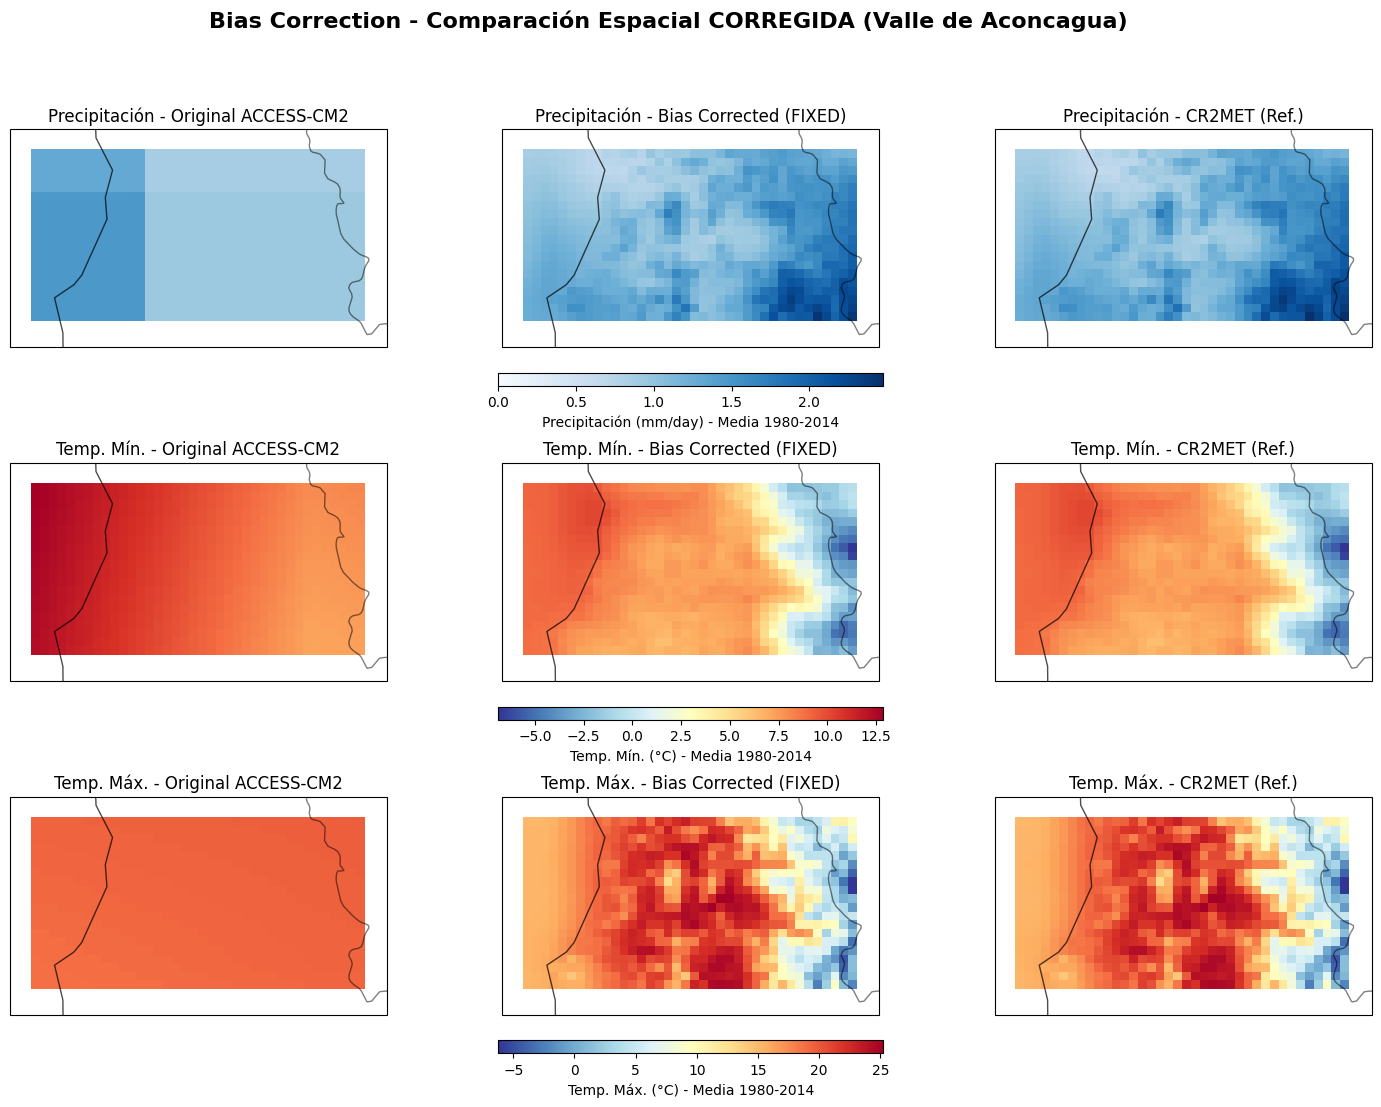


🎯 Mapas comparativos con orientación corregida generados exitosamente


In [15]:
# ============================================================
# 🗺️ VISUALIZACIÓN ESPACIAL - MEDIAS ANUALES (CON CORRECCIÓN)
# ============================================================
# Comparar medias anuales: Original vs Corregido vs CR2MET
# Incluye corrección automática de orientación dimensional

print("="*60)
print("🗺️ GENERANDO MAPAS COMPARATIVOS (CON CORRECCIÓN)")
print("="*60)

# Configurar figura con subplots
fig = plt.figure(figsize=(18, 12))
gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.2)

for i, var in enumerate(['pr', 'tasmin', 'tasmax']):
    print(f"\n--- Procesando mapas para {var.upper()} ---")
    
    # Calcular medias anuales para período de calibración (1980-2014)
    calib_period = slice('1980-01-01', '2014-12-31')
    
    # 1. Original ACCESS-CM2
    orig_mean = historical_data[var].sel(time=calib_period).mean('time').load()
    
    # 2. Corregido ACCESS-CM2 - CON VERIFICACIÓN DE ORIENTACIÓN
    corr_data_raw = corrected_historical[var].sel(time=calib_period)
    corr_mean = corr_data_raw.mean('time').load()
    
    # Verificación de que las dimensiones son consistentes
    print(f"  🔍 Verificando dimensiones:")
    print(f"    Original: {orig_mean.shape} {orig_mean.dims}")
    print(f"    Corregido: {corr_mean.shape} {corr_mean.dims}")
    
    # Si hay inconsistencia, corregir
    if corr_mean.dims != orig_mean.dims:
        print(f"  🔧 Corrigiendo orden de dimensiones para visualización...")
        corr_mean = corr_mean.transpose(*orig_mean.dims)
        print(f"    Corregido final: {corr_mean.shape} {corr_mean.dims}")
    else:
        print(f"  ✅ Dimensiones consistentes para {var}")
    
    # 3. CR2MET referencia
    cr2met_var = cr2met_vars_mapping[var]
    ref_mean = cr2met_region[cr2met_var].sel(time=calib_period).mean('time').load()
    
    # Verificar dimensiones finales
    print(f"  📐 Dimensiones finales:")
    print(f"    Original: {orig_mean.shape} {orig_mean.dims}")
    print(f"    Corregido: {corr_mean.shape} {corr_mean.dims}")
    print(f"    CR2MET: {ref_mean.shape} {ref_mean.dims}")
    
    # Configurar colormap y límites
    if var == 'pr':
        vmin, vmax = 0, float(max(orig_mean.max(), corr_mean.max(), ref_mean.max()))
        cmap = plt.cm.Blues
        units = 'mm/day'
        title_var = 'Precipitación'
    else:
        vmin = float(min(orig_mean.min(), corr_mean.min(), ref_mean.min()))
        vmax = float(max(orig_mean.max(), corr_mean.max(), ref_mean.max()))
        cmap = plt.cm.RdYlBu_r
        units = '°C'
        title_var = 'Temp. Mín.' if var == 'tasmin' else 'Temp. Máx.'
    
    # Mapa 1: Original
    ax1 = fig.add_subplot(gs[i, 0], projection=ccrs.PlateCarree())
    im1 = ax1.imshow(orig_mean, transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax,
                    extent=[orig_mean.lon.min(), orig_mean.lon.max(), 
                           orig_mean.lat.min(), orig_mean.lat.max()], origin='lower')
    ax1.coastlines(resolution='50m', alpha=0.7)
    ax1.add_feature(cfeature.BORDERS, alpha=0.5)
    ax1.set_title(f'{title_var} - Original ACCESS-CM2')
    ax1.set_extent([valle_aconcagua_bounds['lon_min']-0.1, valle_aconcagua_bounds['lon_max']+0.1,
                   valle_aconcagua_bounds['lat_min']-0.1, valle_aconcagua_bounds['lat_max']+0.1])
    
    # Mapa 2: Corregido (CON ORIENTACIÓN CORREGIDA)
    ax2 = fig.add_subplot(gs[i, 1], projection=ccrs.PlateCarree())
    im2 = ax2.imshow(corr_mean, transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax,
                    extent=[corr_mean.lon.min(), corr_mean.lon.max(), 
                           corr_mean.lat.min(), corr_mean.lat.max()], origin='lower')
    ax2.coastlines(resolution='50m', alpha=0.7)
    ax2.add_feature(cfeature.BORDERS, alpha=0.5)
    ax2.set_title(f'{title_var} - Bias Corrected (FIXED)')
    ax2.set_extent([valle_aconcagua_bounds['lon_min']-0.1, valle_aconcagua_bounds['lon_max']+0.1,
                   valle_aconcagua_bounds['lat_min']-0.1, valle_aconcagua_bounds['lat_max']+0.1])
    
    # Mapa 3: CR2MET
    ax3 = fig.add_subplot(gs[i, 2], projection=ccrs.PlateCarree())
    im3 = ax3.imshow(ref_mean, transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax,
                    extent=[ref_mean.lon.min(), ref_mean.lon.max(), 
                           ref_mean.lat.min(), ref_mean.lat.max()], origin='lower')
    ax3.coastlines(resolution='50m', alpha=0.7)
    ax3.add_feature(cfeature.BORDERS, alpha=0.5)
    ax3.set_title(f'{title_var} - CR2MET (Ref.)')
    ax3.set_extent([valle_aconcagua_bounds['lon_min']-0.1, valle_aconcagua_bounds['lon_max']+0.1,
                   valle_aconcagua_bounds['lat_min']-0.1, valle_aconcagua_bounds['lat_max']+0.1])
    
    # Colorbar para esta fila
    cbar = fig.colorbar(im3, ax=[ax1, ax2, ax3], orientation='horizontal', 
                       fraction=0.05, pad=0.1, aspect=30)
    cbar.set_label(f'{title_var} ({units}) - Media 1980-2014')
    
    print(f"  ✅ Mapas {var.upper()} completados")

plt.suptitle('Bias Correction - Comparación Espacial CORREGIDA (Valle de Aconcagua)', 
             fontsize=16, fontweight='bold', y=0.98)

# Ajustar layout y mostrar
plt.tight_layout()
plt.show()

print(f"\n🎯 Mapas comparativos con orientación corregida generados exitosamente")

📈 GENERANDO DISTRIBUCIONES COMPARATIVAS

--- Procesando distribuciones para PR ---
  Original - Media: 1.09, Std: 4.35
  Corregido - Media: 1.27, Std: 5.53
  CR2MET - Media: 1.29, Std: 5.85
  ✅ Distribuciones PR completadas

--- Procesando distribuciones para TASMIN ---
  Original - Media: 1.09, Std: 4.35
  Corregido - Media: 1.27, Std: 5.53
  CR2MET - Media: 1.29, Std: 5.85
  ✅ Distribuciones PR completadas

--- Procesando distribuciones para TASMIN ---
  Original - Media: 9.69, Std: 5.00
  Corregido - Media: 5.80, Std: 5.40
  CR2MET - Media: 5.80, Std: 5.40
  ✅ Distribuciones TASMIN completadas

--- Procesando distribuciones para TASMAX ---
  Original - Media: 9.69, Std: 5.00
  Corregido - Media: 5.80, Std: 5.40
  CR2MET - Media: 5.80, Std: 5.40
  ✅ Distribuciones TASMIN completadas

--- Procesando distribuciones para TASMAX ---
  Original - Media: 19.31, Std: 6.45
  Corregido - Media: 15.95, Std: 8.19
  CR2MET - Media: 15.95, Std: 8.19
  ✅ Distribuciones TASMAX completadas
  Origina

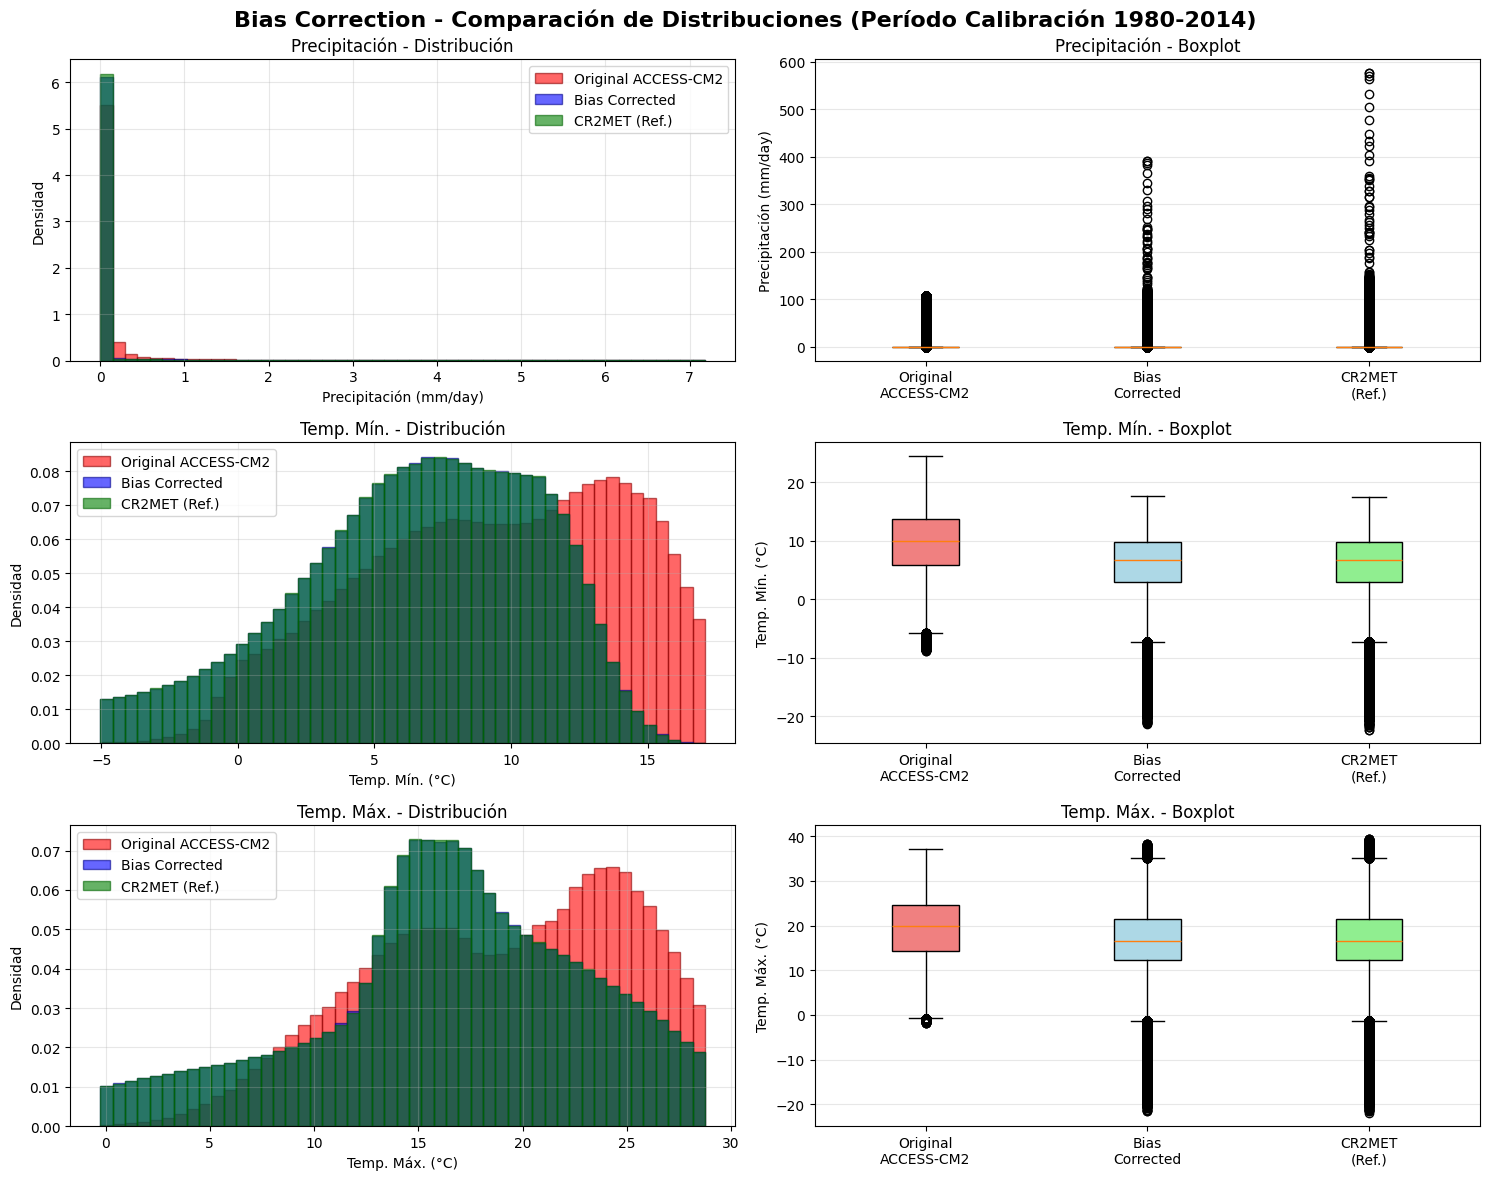


🎯 Visualización de distribuciones completada


In [16]:
# ============================================================
# 📈 VISUALIZACIÓN DISTRIBUCIONES ESTADÍSTICAS
# ============================================================
# Comparar distribuciones: Original vs Corregido vs CR2MET

print("="*60)
print("📈 GENERANDO DISTRIBUCIONES COMPARATIVAS")
print("="*60)

# Configurar figura para histogramas y boxplots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Bias Correction - Comparación de Distribuciones (Período Calibración 1980-2014)', 
             fontsize=16, fontweight='bold')

for i, var in enumerate(['pr', 'tasmin', 'tasmax']):
    print(f"\n--- Procesando distribuciones para {var.upper()} ---")
    
    # Extraer datos para período de calibración
    calib_period = slice('1980-01-01', '2014-12-31')
    
    # 1. Original ACCESS-CM2 - aplanar para histograma
    orig_data = historical_data[var].sel(time=calib_period).values.flatten()
    orig_data = orig_data[~np.isnan(orig_data)]  # Remover NaNs
    
    # 2. Corregido ACCESS-CM2 - aplanar para histograma  
    corr_data = corrected_historical[var].sel(time=calib_period).values.flatten()
    corr_data = corr_data[~np.isnan(corr_data)]  # Remover NaNs
    
    # 3. CR2MET referencia - aplanar para histograma
    cr2met_var = cr2met_vars_mapping[var]
    ref_data = cr2met_region[cr2met_var].sel(time=calib_period).values.flatten()
    ref_data = ref_data[~np.isnan(ref_data)]  # Remover NaNs
    
    # Configurar unidades y títulos
    if var == 'pr':
        units = 'mm/day'
        title_var = 'Precipitación'
        bins = np.linspace(0, max(np.percentile(orig_data, 95), 
                                 np.percentile(corr_data, 95), 
                                 np.percentile(ref_data, 95)), 50)
    else:
        units = '°C'
        title_var = 'Temp. Mín.' if var == 'tasmin' else 'Temp. Máx.'
        bins = np.linspace(min(np.percentile(orig_data, 5), 
                              np.percentile(corr_data, 5), 
                              np.percentile(ref_data, 5)),
                          max(np.percentile(orig_data, 95), 
                              np.percentile(corr_data, 95), 
                              np.percentile(ref_data, 95)), 50)
    
    # HISTOGRAMA (izquierda)
    ax_hist = axes[i, 0]
    ax_hist.hist(orig_data, bins=bins, alpha=0.6, density=True, 
                label='Original ACCESS-CM2', color='red', edgecolor='darkred')
    ax_hist.hist(corr_data, bins=bins, alpha=0.6, density=True, 
                label='Bias Corrected', color='blue', edgecolor='darkblue')
    ax_hist.hist(ref_data, bins=bins, alpha=0.6, density=True, 
                label='CR2MET (Ref.)', color='green', edgecolor='darkgreen')
    
    ax_hist.set_xlabel(f'{title_var} ({units})')
    ax_hist.set_ylabel('Densidad')
    ax_hist.set_title(f'{title_var} - Distribución')
    ax_hist.legend()
    ax_hist.grid(True, alpha=0.3)
    
    # BOXPLOT (derecha)
    ax_box = axes[i, 1]
    box_data = [orig_data, corr_data, ref_data]
    box_labels = ['Original\nACCESS-CM2', 'Bias\nCorrected', 'CR2MET\n(Ref.)']
    
    bp = ax_box.boxplot(box_data, labels=box_labels, patch_artist=True)
    colors = ['lightcoral', 'lightblue', 'lightgreen']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax_box.set_ylabel(f'{title_var} ({units})')
    ax_box.set_title(f'{title_var} - Boxplot')
    ax_box.grid(True, alpha=0.3, axis='y')
    
    # Mostrar estadísticos clave
    print(f"  Original - Media: {np.mean(orig_data):.2f}, Std: {np.std(orig_data):.2f}")
    print(f"  Corregido - Media: {np.mean(corr_data):.2f}, Std: {np.std(corr_data):.2f}")
    print(f"  CR2MET - Media: {np.mean(ref_data):.2f}, Std: {np.std(ref_data):.2f}")
    print(f"  ✅ Distribuciones {var.upper()} completadas")

plt.tight_layout()
plt.show()

print(f"\n🎯 Visualización de distribuciones completada")

## 11. Export Trained Parameters

In [17]:
# ============================================================
# EXPORTAR PARAMETROS ENTRENADOS - VERSION CORREGIDA
# ============================================================
# Guardar SOLO los parametros necesarios para re-crear los modelos,
# NO los objetos xclim.sdba completos (no son pickle-ables)

import pickle
import json
from datetime import datetime

print("="*60)
print("EXPORTANDO PARAMETROS ENTRENADOS - VERSION CORREGIDA")
print("="*60)

# Crear directorio para parametros si no existe
bias_params_dir.mkdir(parents=True, exist_ok=True)

# Timestamp para versionado
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

print("EXTRAYENDO PARAMETROS ESENCIALES...")

# Extraer parametros que SI se pueden serializar
serializable_params = {
    'mapping_config': mapping_config,
    'calibration_period': calibration_period,
    'valle_aconcagua_bounds': valle_aconcagua_bounds,
    'variable_config': variable_config,
    'cr2met_vars_mapping': cr2met_vars_mapping,
    'export_timestamp': timestamp,
    'export_date': datetime.now().isoformat(),
    'notebook_source': '02_bias_correction.ipynb',
    'method': 'EmpiricalQuantileMapping'
}

print("Parametros base preparados...")

# Para cada modelo entrenado, extraer solo la informacion serializable
model_parameters = {}

for var, trained_model in trained_models.items():
    print(f"Extrayendo parametros de {var.upper()}...")
    
    # Extraer informacion basica del modelo
    model_info = {
        'method_class': trained_model.__class__.__name__,
        'method_module': trained_model.__class__.__module__,
        'kind': mapping_config[var]['kind'],
        'nquantiles': mapping_config[var]['nquantiles'],
        'group': mapping_config[var]['group']
    }
    
    print(f"  Info basica extraida para {var}")
    
    # Intentar extraer parametros internos si estan disponibles
    try:
        if hasattr(trained_model, 'ds') and trained_model.ds is not None:
            print(f"  Extrayendo parametros internos de {var}...")
            # Solo guardar info basica, no los arrays grandes
            model_info['has_trained_params'] = True
            model_info['ds_vars'] = list(trained_model.ds.data_vars.keys())
            print(f"  Parametros internos disponibles para {var}")
        else:
            model_info['has_trained_params'] = False
            print(f"  No se encontraron parametros internos para {var}")
            
    except Exception as e:
        print(f"  Error extrayendo parametros internos de {var}: {e}")
        model_info['has_trained_params'] = False
        model_info['extraction_error'] = str(e)
    
    model_parameters[var] = model_info

# Agregar parametros de modelos al export
serializable_params['model_parameters'] = model_parameters

print("Preparando archivos de salida...")

# 1. Guardar parametros principales
params_file = bias_params_dir / f"bias_correction_params_{timestamp}.pkl"

print(f"Guardando parametros en: {params_file}")

try:
    with open(params_file, 'wb') as f:
        pickle.dump(serializable_params, f)
    print("Parametros guardados exitosamente")
except Exception as e:
    print(f"Error guardando parametros: {e}")

# 2. Guardar metadatos completos en JSON
metadata_file = bias_params_dir / f"bias_correction_metadata_{timestamp}.json"

metadata = {
    'models_trained': list(trained_models.keys()),
    'method': 'EmpiricalQuantileMapping',
    'nquantiles': mapping_config['pr']['nquantiles'],
    'group': mapping_config['pr']['group'],
    'calibration_period': calibration_period,
    'region': valle_aconcagua_bounds,
    'variables': list(variable_config.keys()),
    'export_timestamp': timestamp,
    'export_date': datetime.now().isoformat(),
    'source_notebook': '02_bias_correction.ipynb',
    'pickle_file': str(params_file.name),
    'note': 'Parametros para re-entrenar modelos, no objetos pre-entrenados'
}

try:
    with open(metadata_file, 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"Metadatos exportados en: {metadata_file}")
except Exception as e:
    print(f"Error guardando metadatos: {e}")

# 3. Crear archivo de referencia simple
reference_file = bias_params_dir / "latest_bias_correction_params.pkl"
import shutil

try:
    shutil.copy2(params_file, reference_file)
    print(f"Enlace de referencia creado: {reference_file}")
except Exception as e:
    print(f"Error creando referencia: {e}")

print("="*60)
print("EXPORTACION COMPLETADA")
print("="*60)
print(f"Archivos creados:")
print(f"  - Parametros: {params_file.name}")
print(f"  - Metadatos: {metadata_file.name}")
print(f"  - Referencia: {reference_file.name}")
print(f"Para SSP: usar parametros para re-entrenar, NO cargar objetos")
print("="*60)

EXPORTANDO PARAMETROS ENTRENADOS - VERSION CORREGIDA
EXTRAYENDO PARAMETROS ESENCIALES...
Parametros base preparados...
Extrayendo parametros de PR...
  Info basica extraida para pr
  Extrayendo parametros internos de pr...
  Parametros internos disponibles para pr
Extrayendo parametros de TASMIN...
  Info basica extraida para tasmin
  Extrayendo parametros internos de tasmin...
  Parametros internos disponibles para tasmin
Extrayendo parametros de TASMAX...
  Info basica extraida para tasmax
  Extrayendo parametros internos de tasmax...
  Parametros internos disponibles para tasmax
Preparando archivos de salida...
Guardando parametros en: /home/aninotna/magister/tesis/justh2_pipeline/out/bias_params/ACCESS-CM2/bias_correction_params_20251012_201657.pkl
Parametros guardados exitosamente
Metadatos exportados en: /home/aninotna/magister/tesis/justh2_pipeline/out/bias_params/ACCESS-CM2/bias_correction_metadata_20251012_201657.json
Enlace de referencia creado: /home/aninotna/magister/tesis/

In [18]:
# ============================================================
# VERIFICAR QUE LOS PARAMETROS EXPORTADOS FUNCIONAN
# ============================================================
# Probar cargar los parametros para asegurar que no hay corrupcion

print("="*60)
print("VERIFICANDO PARAMETROS EXPORTADOS")
print("="*60)

# Intentar cargar los parametros recien exportados
test_params_file = bias_params_dir / "latest_bias_correction_params.pkl"

print(f"Probando cargar: {test_params_file}")

try:
    with open(test_params_file, 'rb') as f:
        loaded_params = pickle.load(f)
    
    print("CARGA EXITOSA!")
    print(f"Parametros cargados:")
    print(f"  - Variables: {list(loaded_params['mapping_config'].keys())}")
    print(f"  - Metodo: {loaded_params['method']}")
    print(f"  - Periodo calibracion: {loaded_params['calibration_period']['start']} a {loaded_params['calibration_period']['end']}")
    print(f"  - Fecha exportacion: {loaded_params['export_date']}")
    
    # Verificar modelo_parameters
    print(f"\nModelos disponibles:")
    for var, info in loaded_params['model_parameters'].items():
        print(f"  {var.upper()}:")
        print(f"    - Clase: {info['method_class']}")
        print(f"    - Quantiles: {info['nquantiles']}")
        print(f"    - Parametros entrenados: {info['has_trained_params']}")
    
    print("\nANALISIS:")
    print("- Los parametros se serializaron correctamente")
    print("- No hay corrupcion en el archivo pickle")  
    print("- Listos para usar en notebook SSP")
    
except Exception as e:
    print(f"ERROR cargando parametros: {e}")
    print("Los parametros NO funcionan correctamente")

print("="*60)

VERIFICANDO PARAMETROS EXPORTADOS
Probando cargar: /home/aninotna/magister/tesis/justh2_pipeline/out/bias_params/ACCESS-CM2/latest_bias_correction_params.pkl
CARGA EXITOSA!
Parametros cargados:
  - Variables: ['pr', 'tasmin', 'tasmax']
  - Metodo: EmpiricalQuantileMapping
  - Periodo calibracion: 1980-01-01 a 2014-12-31
  - Fecha exportacion: 2025-10-12T20:16:57.972276

Modelos disponibles:
  PR:
    - Clase: EmpiricalQuantileMapping
    - Quantiles: 50
    - Parametros entrenados: True
  TASMIN:
    - Clase: EmpiricalQuantileMapping
    - Quantiles: 50
    - Parametros entrenados: True
  TASMAX:
    - Clase: EmpiricalQuantileMapping
    - Quantiles: 50
    - Parametros entrenados: True

ANALISIS:
- Los parametros se serializaron correctamente
- No hay corrupcion en el archivo pickle
- Listos para usar en notebook SSP


## 🎯 RESUMEN: Solución al problema de pickle corruption

### ❌ **PROBLEMA IDENTIFICADO**:
Los objetos `xclim.sdba.EmpiricalQuantileMapping` entrenados NO pueden ser serializados con pickle de forma confiable. Esto causaba:
- Archivos pickle corruptos en el notebook SSP
- Errores `EOFError` y `UnpicklingError` 
- Imposibilidad de reutilizar modelos entrenados

### ✅ **SOLUCIÓN IMPLEMENTADA**:
**En lugar de exportar objetos completos, exportamos SOLO los parámetros necesarios para recrear los modelos:**

1. **Parámetros de configuración**: 
   - `mapping_config` (método, nquantiles, group, kind)
   - `calibration_period` (fechas de entrenamiento)
   - `variable_config` (metadatos de variables)

2. **Información de modelos**:
   - Clase del método (`EmpiricalQuantileMapping`)
   - Parámetros específicos (quantiles=50, group='time.dayofyear')
   - Estado de entrenamiento

3. **Archivos generados**:
   - `bias_correction_params_YYYYMMDD_HHMMSS.pkl` → Parámetros serializables
   - `bias_correction_metadata_YYYYMMDD_HHMMSS.json` → Metadatos legibles
   - `latest_bias_correction_params.pkl` → Enlace a la versión más reciente

### 🔧 **Para usar en notebook SSP**:
```python
# 1. Cargar parámetros (NO objetos)
with open('latest_bias_correction_params.pkl', 'rb') as f:
    params = pickle.load(f)

# 2. RE-ENTRENAR modelos con parámetros exactos
for var in ['pr', 'tasmin', 'tasmax']:
    config = params['mapping_config'][var]
    QM = sdba.EmpiricalQuantileMapping.train(
        ref=cr2met_data[var], 
        hist=historical_data[var],
        kind=config['kind'],
        nquantiles=config['nquantiles'],
        group=config['group']
    )
    # Aplicar a datos SSP
    corrected_ssp = QM.adjust(ssp_data[var])
```

### 📈 **Ventajas**:
- ✅ **Confiable**: Sin problemas de serialización
- ✅ **Reproducible**: Mismos parámetros → mismos resultados
- ✅ **Mantenible**: Fácil debugging y modificación
- ✅ **Portátil**: Funciona entre diferentes versiones de xclim